# Scalp Type Image Classifier using ResNet152v2 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# dataset.zip >> img sharpening 한 dandruff 
from zipfile import ZipFile

with ZipFile('/content/drive/MyDrive/Final_Project/박현우/dataset/dataset_2.zip') as z: 
    z.extractall()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import glob 
import tensorflow as tf
import PIL
from PIL import ImageDraw

from keras import models
from tensorflow.keras.models import Model,load_model,Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense,Flatten, Activation, BatchNormalization,Input,Add,ZeroPadding2D,AveragePooling2D,GlobalMaxPooling2D,MaxPool2D
from keras import optimizers
from keras import regularizers
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet_v2 import ResNet152V2, ResNet50V2, preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions


from sklearn.metrics import confusion_matrix

Train_data, Validation, Test >> dandruff, erythema, hairloss, folliculitis, oily_scalp, dry_scalp 총 6가지 두피 타입 이미지 데이터셋이 있음

### dry_scalp 이미지 데이터 불러오기

In [ ]:
train_path = '/content/drive/MyDrive/Final_Project/Train_data/dry_scalp'
valid_path = '/content/drive/MyDrive/Final_Project/Validation/dry_scalp'
test_path = '/content/drive/MyDrive/Final_Project/Test/dry_scalp'

In [ ]:
train_path

'/content/drive/MyDrive/Final_Project/Train_data/dry_scalp'

### oily_scalp 이미지 데이터 불러오기

In [ ]:
train_path = '/content/drive/MyDrive/Final_Project/Train_data/oily_scalp'
valid_path = '/content/drive/MyDrive/Final_Project/Validation/oily_scalp'
test_path = '/content/drive/MyDrive/Final_Project/Test/oily_scalp'

### dandruff 이미지 불러오기

In [ ]:
train_path = '/content/drive/MyDrive/Final_Project/Train_data/dandruff'
valid_path = '/content/drive/MyDrive/Final_Project/Validation/dandruff'
test_path = '/content/drive/MyDrive/Final_Project/Test/dandruff'

In [ ]:
# zip해제 후
train_path = '/content/train/dandruff'
valid_path = '/content/val/dandruff'
test_path = '/content/test/dandruff'

### erythema 이미지 불러오기

In [ ]:
train_path = '/content/drive/MyDrive/Final_Project/Train_data/erythema'
valid_path = '/content/drive/MyDrive/Final_Project/Validation/erythema'
test_path = '/content/drive/MyDrive/Final_Project/Test/erythema'

### folliculitis 이미지 불러오기


In [ ]:
train_path = '/content/drive/MyDrive/Final_Project/Train_data/folliculitis'
valid_path = '/content/drive/MyDrive/Final_Project/Validation/folliculitis'
test_path = '/content/drive/MyDrive/Final_Project/Test/folliculitis'

In [ ]:
# 전처리된 이미지
train_path = '/content/drive/MyDrive/final_pjt/dataset/train/folliculitis'
valid_path = '/content/drive/MyDrive/final_pjt/dataset/val/folliculitis'
test_path = '/content/drive/MyDrive/final_pjt/dataset/test/folliculitis'

###                                                            이미지 불러오기

In [ ]:
train_path = '/content/drive/MyDrive/Final_Project/Train_data/folliculitis'
valid_path = '/content/drive/MyDrive/Final_Project/Validation/folliculitis'
test_path = '/content/drive/MyDrive/Final_Project/Test/folliculitis'

------------------------------

### Image generator

In [ ]:
subject = train_path.split('/')[-1]
subject

'dandruff'

In [ ]:
# image labels

labels=pd.Series(os.listdir(train_path))

labels=labels.sort_values()
labels=labels.to_list()
labels

['dandruff_0', 'dandruff_1', 'dandruff_2', 'dandruff_3']

In [ ]:
image_height = 224  # 이미지 높이
image_width = 224   # 이미지 넓이
batch_size = 32     # batch size
epochs  = 20  # trining 횟수

In [ ]:
# ImageDataGenerator 클래스를 통해 train_datagen, val_datagen 인스턴스를 생성.
# 픽셀 값을 0~1 범위로 변환

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# train_datagen 인스턴스를 통해 train dataset 에서 한번에 batch_size 만큼 이미지를 만들어내는 training_set 객체를 생성.
train_set = train_datagen.flow_from_directory(train_path,
                                                 target_size=(image_width, image_height),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')


# val_datagen 인스턴스를 통해 test dataset 에서 한번에 batch_size 만큼 이미지를 만들어내는 test_set 객체를 생성.
test_set = test_datagen.flow_from_directory(test_path,                                            
                                            target_size=(image_width, image_height),
                                            batch_size=batch_size,
                                            class_mode='categorical')

#val_datagen 인스턴스를 통해 val dataset 에서 한번에 batch_size 만큼 이미지를 만들어내는 val_set 객체를 생성.
val_set = val_datagen.flow_from_directory(valid_path,                                        
                                           target_size=(image_width, image_height),
                                           batch_size=batch_size,
                                           class_mode='categorical')

Found 19712 images belonging to 4 classes.
Found 4123 images belonging to 4 classes.
Found 8218 images belonging to 4 classes.


In [ ]:
class_path = glob.glob(train_path + '/*')
class_path

['/content/train/dandruff/dandruff_1',
 '/content/train/dandruff/dandruff_3',
 '/content/train/dandruff/dandruff_0',
 '/content/train/dandruff/dandruff_2']

In [ ]:
# 각각의 data set 이 만들어 내는 이미지의 클래스 인덱스 확인
print(f'train set의 이미지 클래스: {train_set.class_indices}')
print(f'test set의 이미지 클래스: {test_set.class_indices}')
print(f'validation set의 이미지 클래스: {val_set.class_indices}')

train set의 이미지 클래스: {'dandruff_0': 0, 'dandruff_1': 1, 'dandruff_2': 2, 'dandruff_3': 3}
test set의 이미지 클래스: {'dandruff_0': 0, 'dandruff_1': 1, 'dandruff_2': 2, 'dandruff_3': 3}
validation set의 이미지 클래스: {'dandruff_0': 0, 'dandruff_1': 1, 'dandruff_2': 2, 'dandruff_3': 3}


In [ ]:
classNum = []
fileNum = []
for path in class_path :
    fileNum.append(len(glob.glob(path + '/*')))
    classNum.append(int(path.split('_')[-1]))

label_dic = dict(zip(classNum, fileNum))
label_dic

{0: 534, 1: 8031, 2: 8891, 3: 2256}

### 모델링

In [ ]:
conv_base = ResNet50V2(include_top=False, weights = 'imagenet' ,input_shape=(224,224,3))
conv_base.trainable = True
# conv_base.summary()


In [ ]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))
# model.summary()

In [ ]:
for i, layer in enumerate(conv_base.layers) :
  print(i, layer.name)

In [ ]:
for layer in conv_base.layers[528:] :
  layer.trainable = True

In [ ]:
# optimizer 정의

opt = tf.keras.optimizers.Adam(learning_rate= 0.0001)

In [ ]:
# 모델 학습시 가장 최신의 최고 모델을 저장하는 인스턴스를 정의
modelCheckpoint = ModelCheckpoint(f'/content/drive/MyDrive/Final_Project/박현우/model/{subject}_resnet_cv2.h5', save_best_only=True)

# 모델 학습시 정확도를 모니터링하여 조기에 학습을 종료시키는 인스턴스 정의
monitor_val_acc = EarlyStopping(monitor='val_acc', patience=7)

# callback 정의
callbacks= [modelCheckpoint,monitor_val_acc]

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['acc'])

In [ ]:
resnet152v2_history =model.fit(train_set,
                    steps_per_epoch=2400//batch_size,
                    epochs=epochs,
                    validation_data=val_set,
                    validation_steps=800//batch_size,
                    callbacks=callbacks
                   )

Epoch 1/20
75/75 [==============================] - 39s 390ms/step - loss: 0.7355 - acc: 0.7529 - val_loss: 7.2751 - val_acc: 0.1850
Epoch 2/20
75/75 [==============================] - 28s 366ms/step - loss: 0.2932 - acc: 0.8804 - val_loss: 6.9640 - val_acc: 0.2262
Epoch 3/20
75/75 [==============================] - 27s 359ms/step - loss: 0.3018 - acc: 0.8963 - val_loss: 4.9949 - val_acc: 0.3125
Epoch 4/20
75/75 [==============================] - 21s 281ms/step - loss: 0.2231 - acc: 0.9125 - val_loss: 6.2003 - val_acc: 0.2812
Epoch 5/20
75/75 [==============================] - 25s 334ms/step - loss: 0.2104 - acc: 0.9304 - val_loss: 4.3291 - val_acc: 0.4275
Epoch 6/20
75/75 [==============================] - 20s 266ms/step - loss: 0.1959 - acc: 0.9233 - val_loss: 4.4228 - val_acc: 0.4313
Epoch 7/20
75/75 [==============================] - 25s 333ms/step - loss: 0.1918 - acc: 0.9312 - val_loss: 3.8294 - val_acc: 0.4275
Epoch 8/20
75/75 [==============================] - 19s 257ms/step - 

In [ ]:
# resnet_model 모델 평가
(test_loss, test_accuracy) = model.evaluate(test_set, steps=800//batch_size, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy*100)

25/25 [==============================] - 3s 135ms/step - loss: 8.6754 - acc: 0.3663
Test loss: 8.675362586975098
Test accuracy: 36.62500083446503


In [ ]:
# font 설정

font1 = {'family': 'DejaVu Sans',
         'weight': 'bold',
         'size': 20
         }

font2 = {'family': 'DejaVu Sans',
         'size': 16
         }   

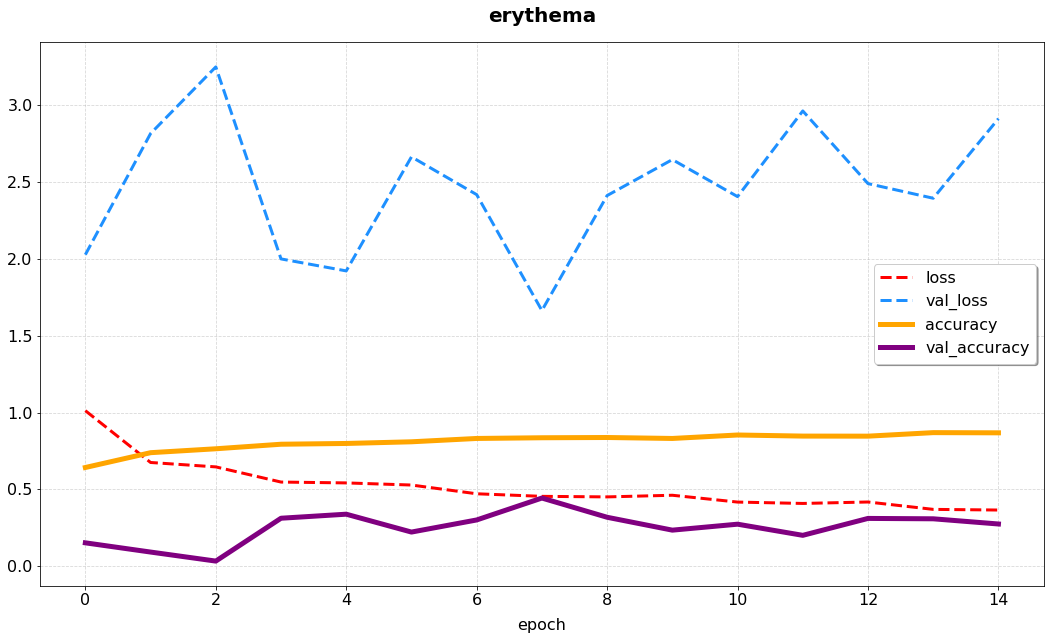

In [ ]:
plt.figure(figsize=(18,10))

plt.plot(resnet152v2_history.history['loss'], '--', c = 'red', label = 'loss', linewidth = 3)
plt.plot(resnet152v2_history.history['val_loss'], '--', c = 'dodgerblue', label = 'val_loss', linewidth = 3)
plt.plot(resnet152v2_history.history['acc'], c='orange',label = 'accuracy', linewidth = 5)
plt.plot(resnet152v2_history.history['val_acc'],c='purple',label = 'val_accuracy', linewidth = 5)


plt.legend(['loss', 'val_loss','accuracy','val_accuracy'],shadow = True, loc='best',fontsize = 16)
plt.title('erythema', fontdict=font1, pad = 20)
plt.xlabel('epoch', fontdict=font2, labelpad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, alpha=0.5, linestyle='--')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(test_set)
classes = test_set.classes[test_set.index_array]
y_pred = np.argmax(Y_pred, axis=1)

result_dict = dict(map(reversed, test_set.class_indices.items()))
class_names = list(result_dict.values())

print('-- Confusion Matrix --')
print(confusion_matrix(classes, y_pred))

print('-- Classification Report --')
print(classification_report(classes, y_pred, target_names=class_names))

In [ ]:
ax = plt.subplot()
sns.heatmap(confusion_matrix(classes, y_pred), annot=True, fmt='d' )
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title(f'{subject}_confusion matrix')